# Data Visualization Notebook

**Make sure that you have run data_collection.ipynb before running this one.**

## Objectives

- Address business requiremenent 1:
    - The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

This notebook will use the following inputs:
- inputs/cherry-leaves/cherry-leaves/test
- inputs/cherry-leaves/cherry-leaves/train
- inputs/cherry-leaves/cherry-leaves/validation

## Outputs

This notebook will generate the following outputs:
- A pickle file storing image shape embeddings (image data stored as a numercal representation) 
- Plots that show the mean (average) image and variability of images for each label
- A plot to show the difference beween healthy leaves and mildewed leaves
- Code to address business requirement 1 and build an image montage

## Import Packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
sns.set_style("white")
from pathlib import Path
from matplotlib.image import imread
from PIL import Image
from tensorflow.keras.preprocessing import image

## Change working directory

By default, the working directory is "jupyter_notebooks", where the notebook is running. However, we need to change the working directory to its parent folder so that file references align with the broader project structure.

To do this, we first check the current working directory — note that the output below only displays the last two folders in the file path, rather than the full system path. This is done intentionally to prevent exposing the full local file path stored on my machine.

**Any time you revisit this notebook after logging out, or open a different notebook for the first time, you must repeat these steps to ensure the working directory is always correctly set.**

In [3]:
import os
from pathlib import Path # ensure file path consistency

# Get the current working directory
current_dir = Path.cwd()

# Extract the last two directory names
filtered_path = Path(*current_dir.parts[-2:])
print(f"📂 {filtered_path}")  # Example output: 📂 mildew_detector/jupyter_notebooks

📂 mildew_detector\jupyter_notebooks


Now we change the working directory from "jupyter_notebooks" to the parent directory.

In [4]:
# Change the working directory to its parent folder
os.chdir(os.path.dirname(os.getcwd()))

# Confirmation message with
print("✅ You set a new current directory")

✅ You set a new current directory


Confirm the new current directory.

In [5]:
# Get the current working directory
current_dir = Path.cwd()

# Extract the last two directory names
filtered_path = Path(*current_dir.parts[-2:])
print(f"📂 {filtered_path}")  # Example output: 📂 mildew_detector/jupyter_notebooks

📂 Projects\mildew_detector


### Set the input directories

Now we need to define the paths where this notebook will find the data we'll be using.

In [6]:
# Define base image data path
image_data = Path("inputs") / "cherry-leaves" / "cherry-leaves"

# Define paths for train, validation, and test sets
train_path = image_data / "train"
val_path = image_data / "validation"
test_path = image_data / "test"

# Print paths
print(f"📂 Train Path: {train_path}")
print(f"📂 Validation Path: {val_path}")
print(f"📂 Test Path: {test_path}")

📂 Train Path: inputs\cherry-leaves\cherry-leaves\train
📂 Validation Path: inputs\cherry-leaves\cherry-leaves\validation
📂 Test Path: inputs\cherry-leaves\cherry-leaves\test


### Confrim that the file paths are valid

Now we'll run a function just to check that the file paths defined above are valid.

The function will select one image from each train, test and validation folder and display it below along with the file path beginning with the "inputs" folder.

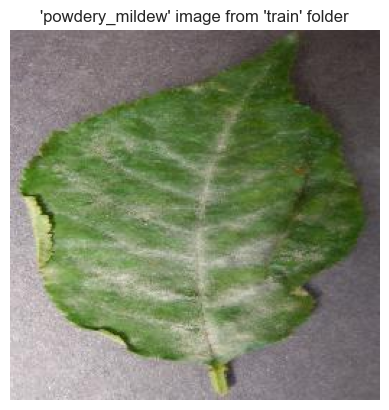

✅ random train image: inputs\cherry-leaves\cherry-leaves\train\powdery_mildew\042ef107-ff5c-4b88-8597-70fc7e82f178___FREC_Pwd.M 4624.JPG


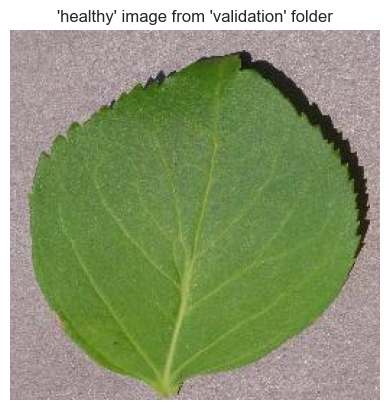

✅ random validation image: inputs\cherry-leaves\cherry-leaves\validation\healthy\b84846ee-4d65-4404-8053-ad9bc9391b2f___JR_HL 9503.JPG


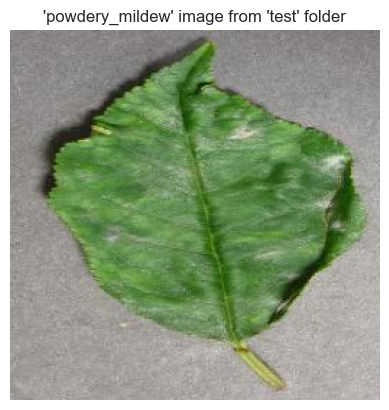

✅ random test image: inputs\cherry-leaves\cherry-leaves\test\powdery_mildew\9772d53b-c48b-472c-86cb-24d0de2446a6___FREC_Pwd.M 0327.JPG


In [7]:
from pathlib import Path

# Function to find and display a random image from subfolders
def show_random_image(parent_folder):
    """
    Selects and displays a random image from a subfolder inside the given parent directory.

    Args:
        parent_folder (str or Path): The path to the main dataset folder (e.g., train, validation, test).

    Returns:
        str or None: The full path to the randomly selected image, or None if no images are found.
    """

    parent_folder = Path(parent_folder)  # Ensure it's a Path object

    # Ensure the parent folder exists
    if not parent_folder.exists():
        print(f"❌ path does not exist: {parent_folder}")
        return None

    # Scan subdirectories ('healthy', 'powdery_mildew')
    subfolders = [f for f in parent_folder.iterdir() if f.is_dir()]

    if not subfolders:
        print(f"⚠️ no subfolders found in: {parent_folder}")
        return None

    # Pick a random subfolder (class name)
    chosen_folder = random.choice(subfolders)

    # Find image files inside that subfolder
    image_files = [f for f in chosen_folder.iterdir() if f.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp', '.webp'}]

    if not image_files:
        print(f"⚠️ no images found in: {chosen_folder}")
        return None

    # Select a random image and display it
    chosen_image = random.choice(image_files)

    # Load image using PIL
    image = Image.open(chosen_image)

    # Extract folder name ('healthy'/'powdery_mildew') and dataset section ('train'/'validation'/'test')
    class_name = chosen_folder.name
    dataset_section = parent_folder.name

    # Display the image with correct labeling
    plt.imshow(image)
    plt.title(f"'{class_name}' image from '{dataset_section}' folder")
    plt.axis("off")  # Hide axes for a cleaner look
    plt.show()

    return str(chosen_image)  # Return path for confirmation

# Fetch and display random images from each dataset section
train_image = show_random_image(train_path)
print(f"✅ random train image: {train_image}")

val_image = show_random_image(val_path)
print(f"✅ random validation image: {val_image}")

test_image = show_random_image(test_path)
print(f"✅ random test image: {test_image}")

## Create an "outputs" Directory

We now need a place to store any new files that we'll be creating.

The cell below will check to see if "outputs" already exists. If not, it will create one and set a file path to it.

In [8]:
from pathlib import Path

# Define the root directory
root_dir = Path.cwd()  # Get current working directory
version = "v1"

# Construct the relative path for outputs
file_path = Path("outputs") / version

# Check if the directory for this version already exists
if file_path.exists():
    print(f'⚠️ Old version "{version}" already exists and the file path to it has just been set.') 
    print(f'Create a new version if required. If not, you are good to go!👍')
else:
    try:
        # Create the directory if it doesn't exist
        file_path.mkdir(parents=True, exist_ok=True)
        print(f'✅ Created new directory: 📂 {file_path}')
    except OSError as e:
        print(f'❌ Error creating directory: {e}')

⚠️ Old version "v1" already exists and the file path to it has just been set.
Create a new version if required. If not, you are good to go!👍


## Set the Label Names

Our upcoming binary classification task will require labeled data in order to train. Here we will set the labels to be used in our project:

- 'healthy'
- 'powdery_mildew'

In [9]:
# Set the labels
labels = os.listdir(train_path)
print('🏷️ The labels for the images are', labels)

🏷️ The labels for the images are ['healthy', 'powdery_mildew']


## Data Visualization

Now that the folders are set up and the file paths established, we can turn our attention to generating data visualizations!

We're now starting to focus on meeting business requirement 1: 

- 'The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.'

### Image Shape

We need to understand the average size of the images in out data set. This is called the image shape.

The next cell will compute the average image size on train set. This code:

- Calculates the average height and width of each image
- Plots the dimensions of each image on a scatter plot
- Counts the number of images processed

Credit Code Institute's WalkthroughProject01 for calculation code.

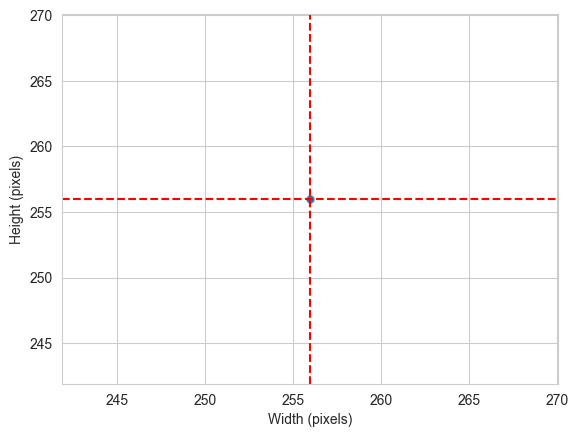

✅ Total images processed: 2944
✅ Width average: 256 
✅ Height average: 256


In [10]:
from pathlib import Path

# Lists to store image dimensions
dim1, dim2 = [], []
image_count = 0  # Initialize a counter for the number of images processed

# Iterate through each label (subdirectories in the training set)
for label in labels:
    label_path = Path(train_path) / label  # Construct label folder path

    # Iterate through each image file within the label's directory
    for image_file in label_path.iterdir():  # Directly iterate through files
        if image_file.suffix.lower() in {'.png', '.jpg', '.jpeg'}:  # Ensure only image files
            # Read the image using PIL
            img = Image.open(image_file)
            d1, d2 = img.size  # PIL returns (width, height)

            # Append the extracted dimensions to their respective lists
            dim1.append(d2)  # Store image height
            dim2.append(d1)  # Store image width

            # Increment the counter to track the number of images processed
            image_count += 1  

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create a figure and an axis for the plot
fig, axes = plt.subplots()

# Scatter plot to visualize width vs height of images
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)  # Semi-transparent points for better visibility

# Label the axes
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")

# Compute the mean (average) image dimensions
dim1_mean = int(np.mean(dim1))  # Average height
dim2_mean = int(np.mean(dim2))  # Average width

# Add dashed reference lines to indicate average dimensions
axes.axvline(x=dim1_mean, color='r', linestyle='--')  # Vertical line for avg width
axes.axhline(y=dim2_mean, color='r', linestyle='--')  # Horizontal line for avg height

# Display the scatter plot
plt.show()

# Print out the total number of images analyzed and the average dimensions
print(f"✅ Total images processed: {image_count}")
print(f"✅ Width average: {dim2_mean} \n✅ Height average: {dim1_mean}")

For training purposes, we should define the image shape as the average widths and heights of all the images in the train set, along with the color channels. The images in this set are all the same size (as seen from the plot above), but it is good practice to calculate the mean of each nevertheless.

In [11]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Now we save the image shape embeddings in the 'outputs' folder for later use.

In [12]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

print(f"📄['{file_path}']")

📄['outputs\v1']
